# Classification and Sequence Labelling

In this coursework you will apply some of the methods learned during the
unit, and explore their behaviour using some real-world datasets. For the
first set of tasks, we will be working with the dataset “Activity recognition
with healthy older people using a batteryless wearable sensor”. This dataset
contains sequences of readings taken from several sensors on a device worn
by a person as they move about in a room. The goal is to predict the activity
label for each data point, i.e., what the person was doing, which may be 1:
sit on bed, 2: sit on chair, 3: lying, or 4: ambulating. To help you accessm
the data, we provide a notebook “activity recognition.ipynb” in our Github
repository (the same repository as the lab worksheets). The notebook code
loads the data into a suitable format for the following tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier

## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [2]:
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

# use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

['d1p22F', 'd1p58F', 'd1p39M', 'd1p37M', 'd1p55F', 'd1p09F', 'd1p30F', 'd1p56F', 'd1p46M', 'd1p59F', 'd1p42M', 'd1p47M', 'd1p08F', 'd1p33F', 'd1p25F', 'd1p14F', 'd1p03M', 'd1p29F', 'd1p02M', 'd1p19F', 'd1p16F', 'd1p20F', 'd1p36M', 'd1p40M', 'd1p57F', 'd1p11F', 'd1p31F', 'd1p13F', 'd1p49F', 'd1p38M', 'd1p41M', 'd1p07M', '.ipynb_checkpoints', 'd1p45M', 'd1p26F', 'README.txt', 'd1p10F', 'd1p35F', 'd1p24F', 'd1p44M', 'd1p52F', 'd1p50F', 'd1p27F', 'd1p01M', 'd1p48M', 'd1p15F', 'd1p53F', 'd1p51F', 'd1p04M', 'd1p28F', 'd1p21F', 'd1p34F', 'd1p06M', 'd1p18F', 'd1p23F', 'd1p12F', 'd1p43M', 'd1p32F', 'd1p54F', 'd1p17F', 'd1p05M', 'd1p60F']
Could not load file .ipynb_checkpoints. Skipping.


## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [3]:
# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?
print(n_states)

4


### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [4]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [5]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])
        
#print(X_given_y[0])

In [6]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [7]:
X_train = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_train = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

X = np.concatenate(X_by_seq, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y = np.concatenate(y_by_seq)  # combine target labels into one list -- use this as target labels for evaluating a classifier


#### Task 1

Implement and evaluate a neural network classifier for the activity
recognition dataset. For this task, ignore the sequence of data points
and use the classification data provided in the notebook. Your report
should cover the following:

- (a) Train a neural network classifier and plot training and validation learning curves. Interpret and discuss your plots, considering over/underfitting.

Accuracy: 0.8766233766233766
Accuracy Score: 0.8766233766233766


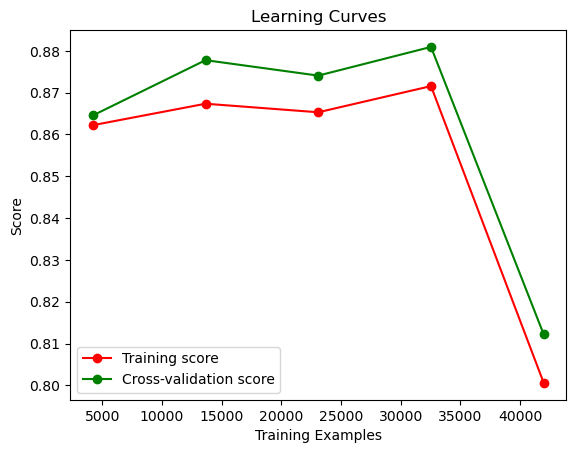

In [8]:
from sklearn.neural_network import MLPClassifier

# Train the classifier
#mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=21)

mlp_model = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', alpha=0.01, learning_rate_init=0.001, batch_size=128, max_iter=3000, n_iter_no_change=25, random_state=21)

mlp_model.fit(X_train, y_train)

# Make predictions
y_pred = mlp_model.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
accuracy_scoree = mlp_model.score(X_test, y_test)
print(f'Accuracy: {accuracy}')
print(f'Accuracy Score: {accuracy_scoree}')
#print(classification_report(y_test, y_pred))

# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(mlp_model, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

'''
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
'''

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc="best")

plt.savefig("classAndSeq1.png")

plt.show()


# Overfitting: The model may be overfitting as it has a high training score but a lower cross-validation score. Overfitting is when the model learns the training data too well, including noise and outliers, which does not generalize well to new data.
# High Training Score: The training score is consistently high across the number of training examples, starting near perfect and remaining flat. This indicates the model is capable of learning the training data very well.
# Increasing Cross-Validation Score: The cross-validation score increases with more training examples, which is typical as more data usually allows the model to generalize better. The curve is still ascending, suggesting that adding more data may continue to improve the model's performance on unseen data.
# Gap Between Curves: There is a noticeable gap between the training and cross-validation scores. This gap indicates some overfitting since the model performs better on the training data than on the unseen cross-validation data. However, the gap does not appear to be widening with more data, which is a good sign.
# Convergence of Curves: The curves do not seem to be converging, which means there might still be room for improvement. In a well-generalized model, we expect the training and validation curves to converge at a high score.


- (b) Present and briefly discuss your results on the test set.

Training set accuracy: 0.877238025992911
Test set accuracy: 0.8766233766233766


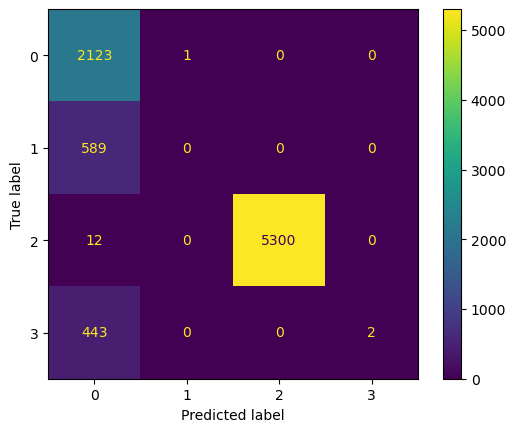

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions on the training set
train_predictions = mlp_model.predict(X_train)

# Predictions on the test set
test_predictions = mlp_model.predict(X_test)

# Accuracy on the training set
train_accuracy = accuracy_score(y_train, train_predictions)

# Accuracy on the test set
test_accuracy = accuracy_score(y_test, test_predictions)

print("Training set accuracy:", train_accuracy)
print("Test set accuracy:", test_accuracy)

cm = confusion_matrix(y_test.flatten(), test_predictions, labels=mlp_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot()
plt.show()


- (c) Which hyperparameters have the strongest effect on model performance? Use plots to help you investigate this.

In [10]:
# Hyperparameters include: the number of hidden layers,
# number of neurons in the hidden layers, learning rate,
# mini-batch size (for stochastic gradient descent optimisers) and regularisation parameter  𝛼
'''
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import matplotlib.pyplot as plt

parameters = {
    'hidden_layer_sizes': [(50,1), (50, 25), (50,), (100,), (150,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [64, 128, 256]
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
mlp = MLPClassifier(max_iter=3000, random_state=21)

for key, params in parameters.items():
    
    print(key)
    param_grid = {key: params}
    grid_search = GridSearchCV(mlp, param_grid, scoring='accuracy', cv=3, verbose=3)
    grid_search.fit(X_train_scaled, y_train)
    grid_search.best_params_
    
    
    if key == 'hidden_layer_sizes':
        value = [str(x) for x in grid_search.param_grid['hidden_layer_sizes']]
    else:
        value = grid_search.param_grid[key]
        
        
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    plt.figure(figsize=(10, 6))
    plt.plot(value, mean_test_scores, marker='o')
    plt.title(f'{key}')
    plt.xlabel('Analysed hyperparameter values')
    plt.ylabel('Mean accuracy score on test dataset')
    plt.grid(True)
    plt.show()
'''

"\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import make_scorer, accuracy_score\nimport matplotlib.pyplot as plt\n\nparameters = {\n    'hidden_layer_sizes': [(50,1), (50, 25), (50,), (100,), (150,)],\n    'activation': ['identity', 'logistic', 'tanh', 'relu'],\n    'solver': ['lbfgs', 'sgd', 'adam'],\n    'alpha': [0.0001, 0.001, 0.01],\n    'learning_rate_init': [0.001, 0.01, 0.1],\n    'batch_size': [64, 128, 256]\n}\n\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nmlp = MLPClassifier(max_iter=3000, random_state=21)\n\nfor key, params in parameters.items():\n    \n    print(key)\n    param_grid = {key: params}\n    grid_search = GridSearchCV(mlp, param_grid, scoring='accuracy', cv=3, verbose=3)\n    grid_search.fit(X_train_scaled, y_train)\n    grid_search.best_params_\n  

#### Task 2

Implement and evaluate an ensemble method using decision trees
as base models. Again, use the activity recognition classification data provided in the notebook and ignore the sequence of data points. 

- (a) Train an ensemble of decision trees, and briefly describe how your ensemble improves performance over a single model.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [12]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a single decision tree
tree_clf = DecisionTreeClassifier(random_state=21)
tree_clf.fit(X_train_scaled, y_train)

# Train a Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=21)
rf_clf.fit(X_train_scaled, y_train)

# Evaluate the single decision tree
y_pred_tree = tree_clf.predict(X_test_scaled)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Single Decision Tree Accuracy: {accuracy_tree}')
print(classification_report(y_test, y_pred_tree))

# Evaluate the Random Forest
y_pred_rf = rf_clf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')
print(classification_report(y_test, y_pred_rf))

'''

This code trains a single decision tree and a Random Forest on the same dataset and evaluates their performance.

How the Ensemble Improves Performance:

Reduced Overfitting: Single decision trees are prone to overfitting the training data, especially with complex datasets. Random Forest mitigates this by averaging the predictions from multiple trees, each trained on a random subset of the data.
Improved Accuracy: By combining the predictions of many trees, Random Forest often achieves higher accuracy than a single decision tree.
Handling Unbalanced Data: Random Forest can handle unbalanced datasets by balancing errors in the individual trees.
Robustness to Noise: Individual trees might be sensitive to noise in the training data, but when combined in an ensemble, the overall effect of noise is reduced.
After running the code, compare the accuracy and other metrics like precision, recall, and F1-score of the single decision tree and the Random Forest. The improvement in these metrics with Random Forest will illustrate the benefits of using an ensemble over a single model.

'''

Single Decision Tree Accuracy: 0.8874852420306966
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2124
           1       0.41      0.35      0.38       589
           2       1.00      1.00      1.00      5312
           3       0.58      0.61      0.59       445

    accuracy                           0.89      8470
   macro avg       0.70      0.69      0.69      8470
weighted avg       0.88      0.89      0.89      8470

Random Forest Accuracy: 0.9181818181818182
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      2124
           1       0.63      0.36      0.46       589
           2       1.00      1.00      1.00      5312
           3       0.90      0.60      0.72       445

    accuracy                           0.92      8470
   macro avg       0.83      0.73      0.76      8470
weighted avg       0.92      0.92      0.91      8470



'\n\nThis code trains a single decision tree and a Random Forest on the same dataset and evaluates their performance.\n\nHow the Ensemble Improves Performance:\n\nReduced Overfitting: Single decision trees are prone to overfitting the training data, especially with complex datasets. Random Forest mitigates this by averaging the predictions from multiple trees, each trained on a random subset of the data.\nImproved Accuracy: By combining the predictions of many trees, Random Forest often achieves higher accuracy than a single decision tree.\nHandling Unbalanced Data: Random Forest can handle unbalanced datasets by balancing errors in the individual trees.\nRobustness to Noise: Individual trees might be sensitive to noise in the training data, but when combined in an ensemble, the overall effect of noise is reduced.\nAfter running the code, compare the accuracy and other metrics like precision, recall, and F1-score of the single decision tree and the Random Forest. The improvement in the

- (b) Present and briefly discuss your results on the test set. 

Training set accuracy: 0.9999318367717895
Test set accuracy: 0.9181818181818182


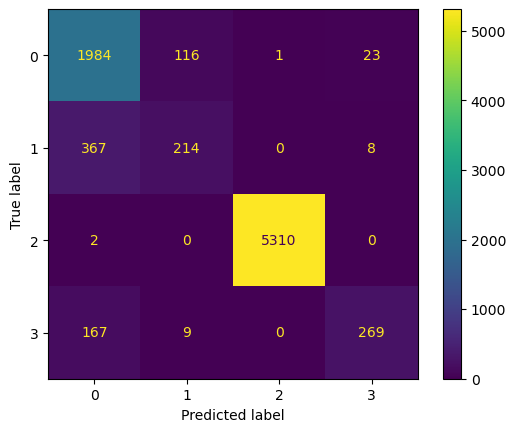

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Predictions on the training set
train_predictions = rf_clf.predict(X_train_scaled)

# Predictions on the test set
test_predictions = rf_clf.predict(X_test_scaled)

# Accuracy on the training set
train_accuracy = accuracy_score(y_train, train_predictions)

# Accuracy on the test set
test_accuracy = accuracy_score(y_test, test_predictions)

print("Training set accuracy:", train_accuracy)
print("Test set accuracy:", test_accuracy)

cm = confusion_matrix(y_test.flatten(), test_predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot()
plt.show()


Accuracy:

Compare the accuracy scores of the single decision tree and the Random Forest. Typically, the Random Forest should have a higher accuracy due to its ensemble nature.
Discuss why there is a difference in accuracy. The ensemble method often performs better due to reduced overfitting and improved generalization.
Precision, Recall, and F1-Score:

Look at these metrics for each class in the classification report.
The Random Forest might show a more balanced performance across different classes compared to the single decision tree, especially if the dataset is imbalanced.
Highlight any significant differences in these metrics between the two models and what they imply about their respective performances.
Overfitting/Underfitting:

If the single decision tree has a much higher accuracy on the training set compared to the test set, but the Random Forest has more consistent performance, it indicates that the Random Forest is better at generalizing and less prone to overfitting.
Discuss the implications of these findings in terms of model robustness and reliability.
General Observations:

If the Random Forest did not outperform the single tree significantly, explore possible reasons, such as the nature of the data, the complexity of the decision boundaries, or the configuration of the models.
Consider any specific characteristics of the dataset that might affect the performance of ensemble methods versus a single model.
Practical Implications:

Reflect on what the results mean for practical applications. For example, if you are developing a model for real-world deployment, consider the trade-offs between the simplicity and interpretability of a single tree versus the improved accuracy but increased complexity of a Random Forest.
Remember, the goal of this discussion is to understand not just which model performed better, but why, and how this relates to the underlying mechanics of single decision trees versus ensemble methods like Random Forests.

- (c) Show the relationship between the error rate of the ensemble, the error rate of individual base models, and the number of base models. Does ensembling improve performance?

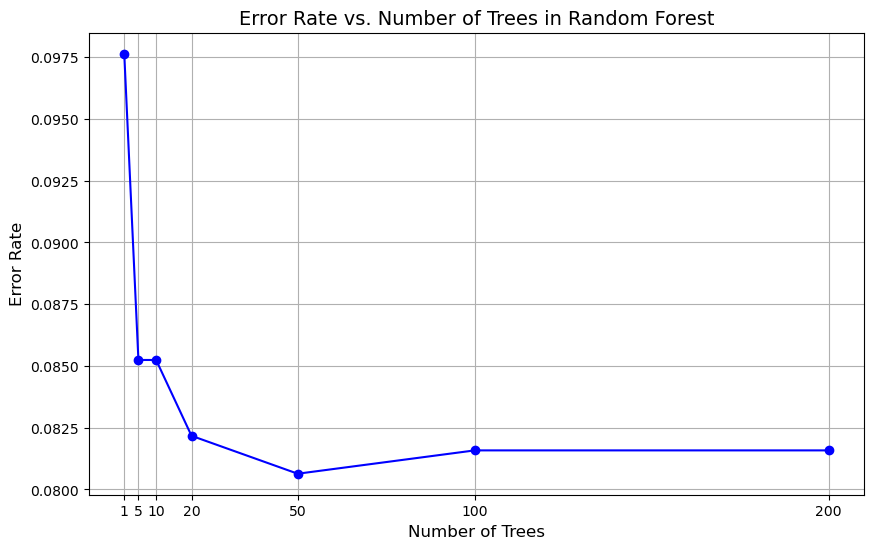

In [14]:
num_trees = [1, 5, 10, 20, 50, 100, 200]
error_rates = []

for n in num_trees:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error_rate = 1 - accuracy_score(y_test, predictions)
    error_rates.append(error_rate)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_trees, error_rates, marker='o', linestyle='-', color='blue')
plt.title('Error Rate vs. Number of Trees in Random Forest', fontsize=14)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.xticks(num_trees)
plt.grid(True)
plt.show()

In this plot:

If the error rate decreases as the number of trees increases, it indicates that ensembling improves performance.
The point at which the error rate starts to plateau indicates the diminishing returns of adding more trees.
Compare the error rates of individual trees (when n_estimators=1) with larger ensembles to highlight the improvement due to ensembling.
This kind of analysis will help you demonstrate the effectiveness of ensemble methods and find the optimal number of trees for your Random Forest model in terms of performance and computational efficiency.







- (d) How sensitive is the model to different hyperparameters (e.g., maximum tree depth)? Use plots to explore the different tradeoffs.

In [46]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score


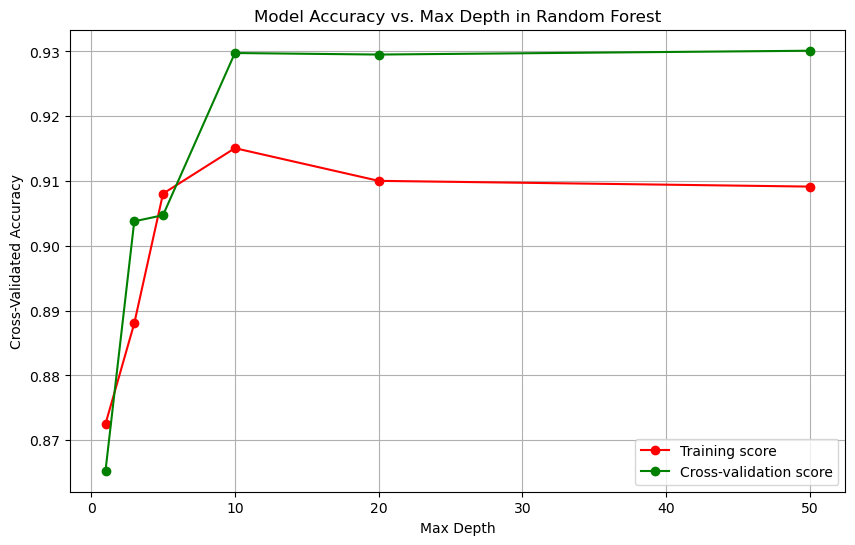

In [43]:
# MAX DEPTH
max_depths = [1, 3, 5, 10, 20, 50, None]  # 'None' means no maximum depth
accuracies_train = []
accuracies_test = []

for depth in max_depths:
    model = RandomForestClassifier(max_depth=depth, random_state=42)
    # Perform cross-validation to evaluate the model
    cv_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    accuracies_train.append(cv_scores_train.mean())
    accuracies_test.append(cv_scores_test.mean())

plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies_train, marker='o', color='r', label="Training score")
plt.plot(max_depths, accuracies_test, marker='o', color='g', label="Cross-validation score")
plt.title('Model Accuracy vs. Max Depth in Random Forest')
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.legend(loc="best")
plt.show()

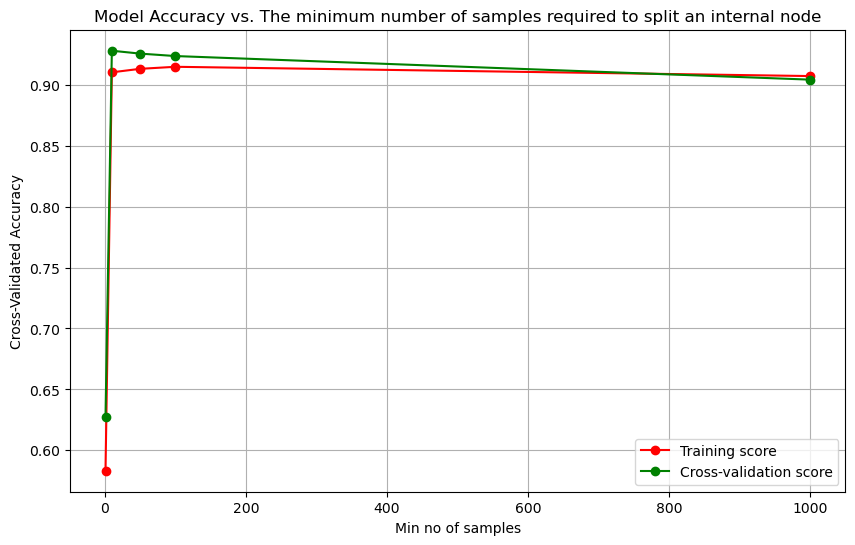

In [48]:
# MIN SAMPLE SPLIT
min_samples_split = [1.0, 10, 50, 100, 1000]
accuracies_train = []
accuracies_test = []

for n in min_samples_split:
    model = RandomForestClassifier(min_samples_split=n, random_state=42)
    # Perform cross-validation to evaluate the model
    cv_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    accuracies_train.append(cv_scores_train.mean())
    accuracies_test.append(cv_scores_test.mean())

plt.figure(figsize=(10, 6))
plt.plot(min_samples_split, accuracies_train, marker='o', color='r', label="Training score")
plt.plot(min_samples_split, accuracies_test, marker='o', color='g', label="Cross-validation score")
plt.title('Model Accuracy vs. The minimum number of samples required to split an internal node')
plt.xlabel('Min no of samples')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.legend(loc="best")
plt.show()

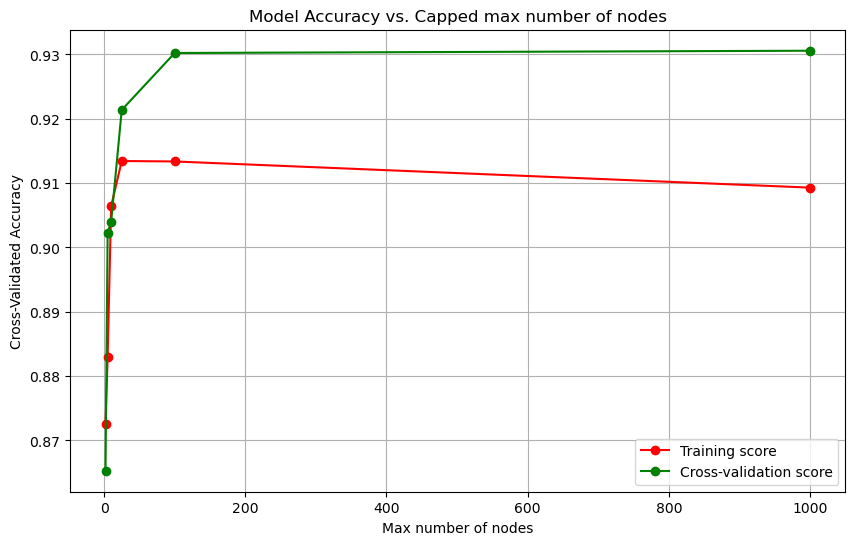

In [51]:
# MAX LEAF NODES
max_leaf_nodes = [2, 5, 10, 25, 100, 1000]
accuracies_train = []
accuracies_test = []

for n in max_leaf_nodes:
    model = RandomForestClassifier(max_leaf_nodes=n, random_state=42)
    # Perform cross-validation to evaluate the model
    cv_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    accuracies_train.append(cv_scores_train.mean())
    accuracies_test.append(cv_scores_test.mean())

plt.figure(figsize=(10, 6))
plt.plot(max_leaf_nodes, accuracies_train, marker='o', color='r', label="Training score")
plt.plot(max_leaf_nodes, accuracies_test, marker='o', color='g', label="Cross-validation score")
plt.title('Model Accuracy vs. Capped max number of nodes')
plt.xlabel('Max number of nodes')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.legend(loc="best")
plt.show()

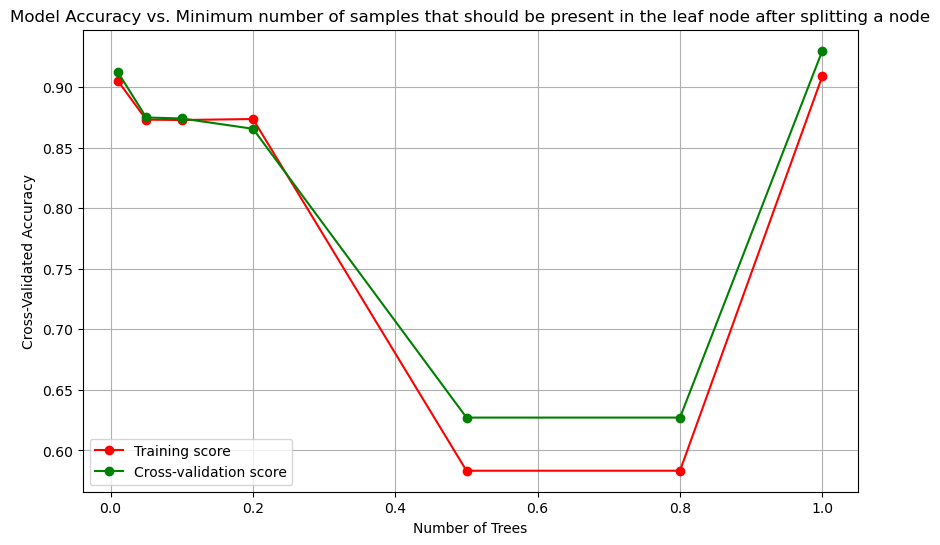

In [ ]:
# MIN SAMPLES LEAF
min_samples_leaf = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1]
accuracies_train = []
accuracies_test = []

for n in min_samples_leaf:
    model = RandomForestClassifier(min_samples_leaf=n, random_state=42)
    # Perform cross-validation to evaluate the model
    cv_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    accuracies_train.append(cv_scores_train.mean())
    accuracies_test.append(cv_scores_test.mean())

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf, accuracies_train, marker='o', color='r', label="Training score")
plt.plot(min_samples_leaf, accuracies_test, marker='o', color='g', label="Cross-validation score")
plt.title('Model Accuracy vs. Minimum number of samples that should be present in the leaf node after splitting a node')
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.legend(loc="best")
plt.show()

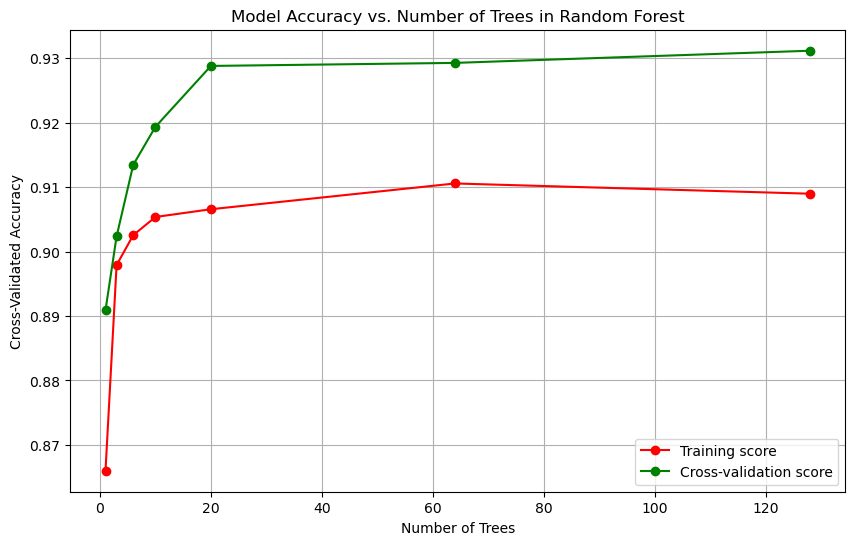

In [45]:
# N ESTIMATORS
n_estimators = [1, 3, 6, 10, 20, 64, 128]
accuracies_train = []
accuracies_test = []

for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    # Perform cross-validation to evaluate the model
    cv_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    accuracies_train.append(cv_scores_train.mean())
    accuracies_test.append(cv_scores_test.mean())

plt.figure(figsize=(10, 6))
plt.plot(n_estimators, accuracies_train, marker='o', color='r', label="Training score")
plt.plot(n_estimators, accuracies_test, marker='o', color='g', label="Cross-validation score")
plt.title('Model Accuracy vs. Number of Trees in Random Forest')
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.legend(loc="best")
plt.show()

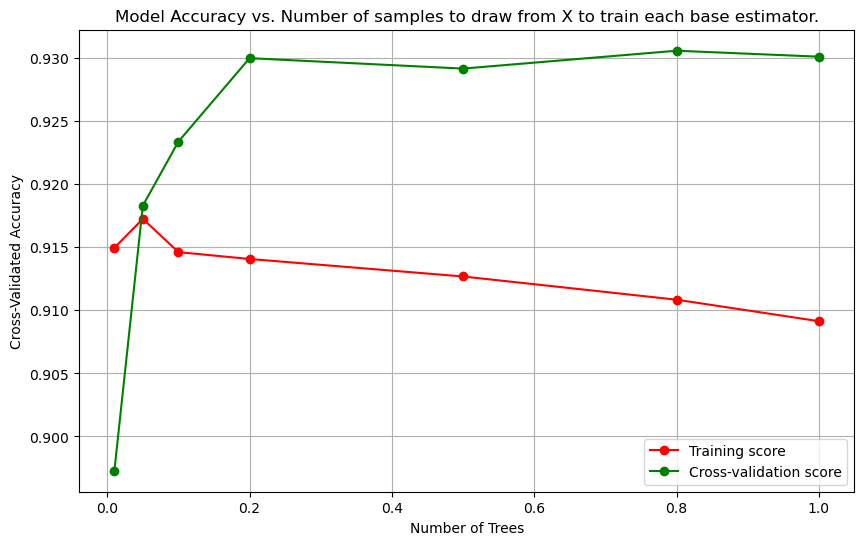

In [55]:
# MAX SAMPLES
max_samples = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0]
accuracies_train = []
accuracies_test = []

for n in max_samples:
    model = RandomForestClassifier(max_samples=n, random_state=42)
    # Perform cross-validation to evaluate the model
    cv_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    accuracies_train.append(cv_scores_train.mean())
    accuracies_test.append(cv_scores_test.mean())

plt.figure(figsize=(10, 6))
plt.plot(max_samples, accuracies_train, marker='o', color='r', label="Training score")
plt.plot(max_samples, accuracies_test, marker='o', color='g', label="Cross-validation score")
plt.title('Model Accuracy vs. Number of samples to draw from X to train each base estimator.')
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.legend(loc="best")
plt.show()

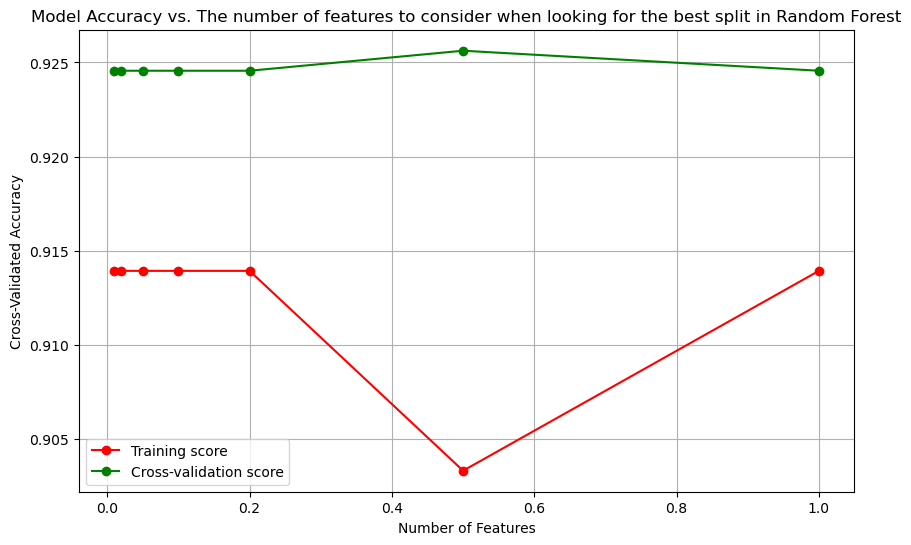

In [58]:
# MAX_FEATURES
#n_features = rf_clf.n_features_in_
#max_features = ['sqrt', 'log2', 1, 3, n_features]
max_features = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
accuracies_train = []
accuracies_test = []


for n in max_features:
    model = RandomForestClassifier(max_features=n, random_state=42)
    # Perform cross-validation to evaluate the model
    cv_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    accuracies_train.append(cv_scores_train.mean())
    accuracies_test.append(cv_scores_test.mean())

plt.figure(figsize=(10, 6))
plt.plot(max_features, accuracies_train, marker='o', color='r', label="Training score")
plt.plot(max_features, accuracies_test, marker='o', color='g', label="Cross-validation score")
plt.title('Model Accuracy vs. The number of features to consider when looking for the best split in Random Forest')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.legend(loc="best")
plt.show()